<a href="https://colab.research.google.com/github/Sameetdmr/Yapay_Zeka_ve_Uzman_Sistemler_Proje/blob/master/G%C3%BCnd%C3%BCz_YAPAY_ZEKA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## 14545027 İhsan SARIYERLİOĞLU
## 15541049 Samed DEMİR

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
# Gerekli Kütüphane Yüklenmesi

from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Google ve dosya bağlantısı

from google.colab import files
uploaded = files.upload()

Saving dataset-resized.zip to dataset-resized.zip


In [0]:
# İndirilen verisetinin açılması

files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

In [0]:
# Veriseti içini gösterme

os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['plastik', 'metal', '.DS_Store', 'cop', 'karton', 'cam', 'kagit']

In [0]:
# Yardımcı fonksiyonlar

# Veriseti içindeki dizinleri rastgele getir. Eğitim ve test şeklinde ayırma

def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    # Eğitim 
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    # temp
    remain = list(set(full_set)-set(train))

    # Doğrulama ve Test için ayırma
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

# Veri türlerine göre çöp türü ayrılması
    # input: Atık Kategorisi
    # output: Dosya adı
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

# Kaynak dosya grubunu başka bir klasöre taşıma
    # input: Kaynak dosyası ve hedef klasörün listesi
    # Çıktısı yok
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [0]:
# Dosya yolları train/karton, train/cam vb..
subsets = ['train','valid'] # Train, test, doğrulama
waste_types = ['karton','cam','metal','kagit','plastik','cop']

# Veri alt kümesi ve atık türü için hedef klasörler oluşturma
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
# Dosyaları her atık türü için hedef klasörüne taşıma
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    # Kaynak dosyalarını eğitime taşıma
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    # Kaynak dosyalarını validation' a taşı
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    # Test etmek için kaynak dosyaları taşıma 
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    # Veri/Test kullanılması düşünüldü çünkü görüntüler karıştırılabilir.
    move_files(test_source_files,"data/test")

In [0]:

# Resim olan klasöre yol verilmesi
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [0]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [0]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastik,plastik,plastik,plastik,plastik
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastik,plastik,plastik,plastik,plastik
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [0]:
print(data.classes)

['cam', 'cop', 'kagit', 'karton', 'metal', 'plastik']


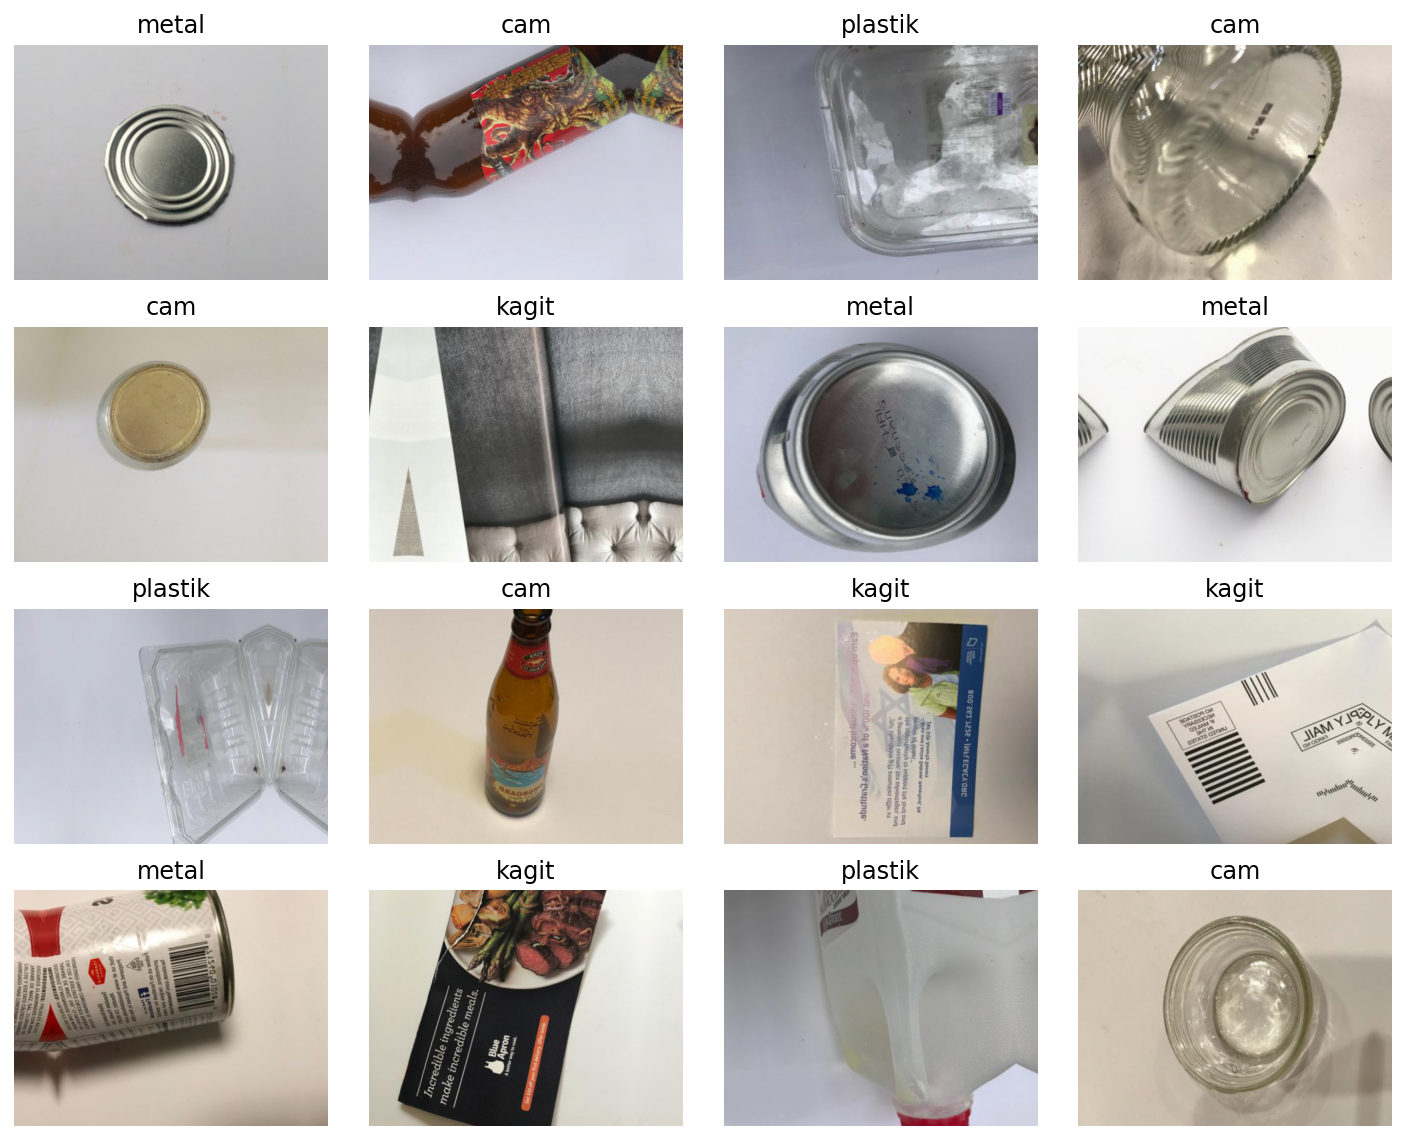

In [0]:
data.show_batch(rows=4,figsize=(10,8))

In [0]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


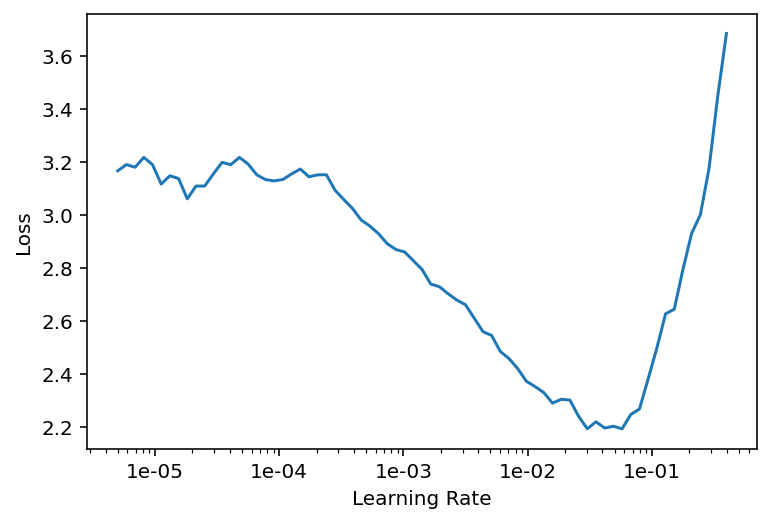

In [0]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(25,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.654683,0.721459,0.261905,00:38
1,1.109266,0.563332,0.182540,00:37
2,0.866029,0.521501,0.160317,00:37
3,0.772659,0.587359,0.165079,00:38
4,0.787345,0.680703,0.212698,00:37
5,0.832621,0.695905,0.207937,00:38
6,0.774004,0.647562,0.206349,00:38
7,0.725215,0.516436,0.157143,00:37
8,0.628617,0.576553,0.173016,00:37
9,0.646076,0.630492,0.201587,00:37


In [0]:

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

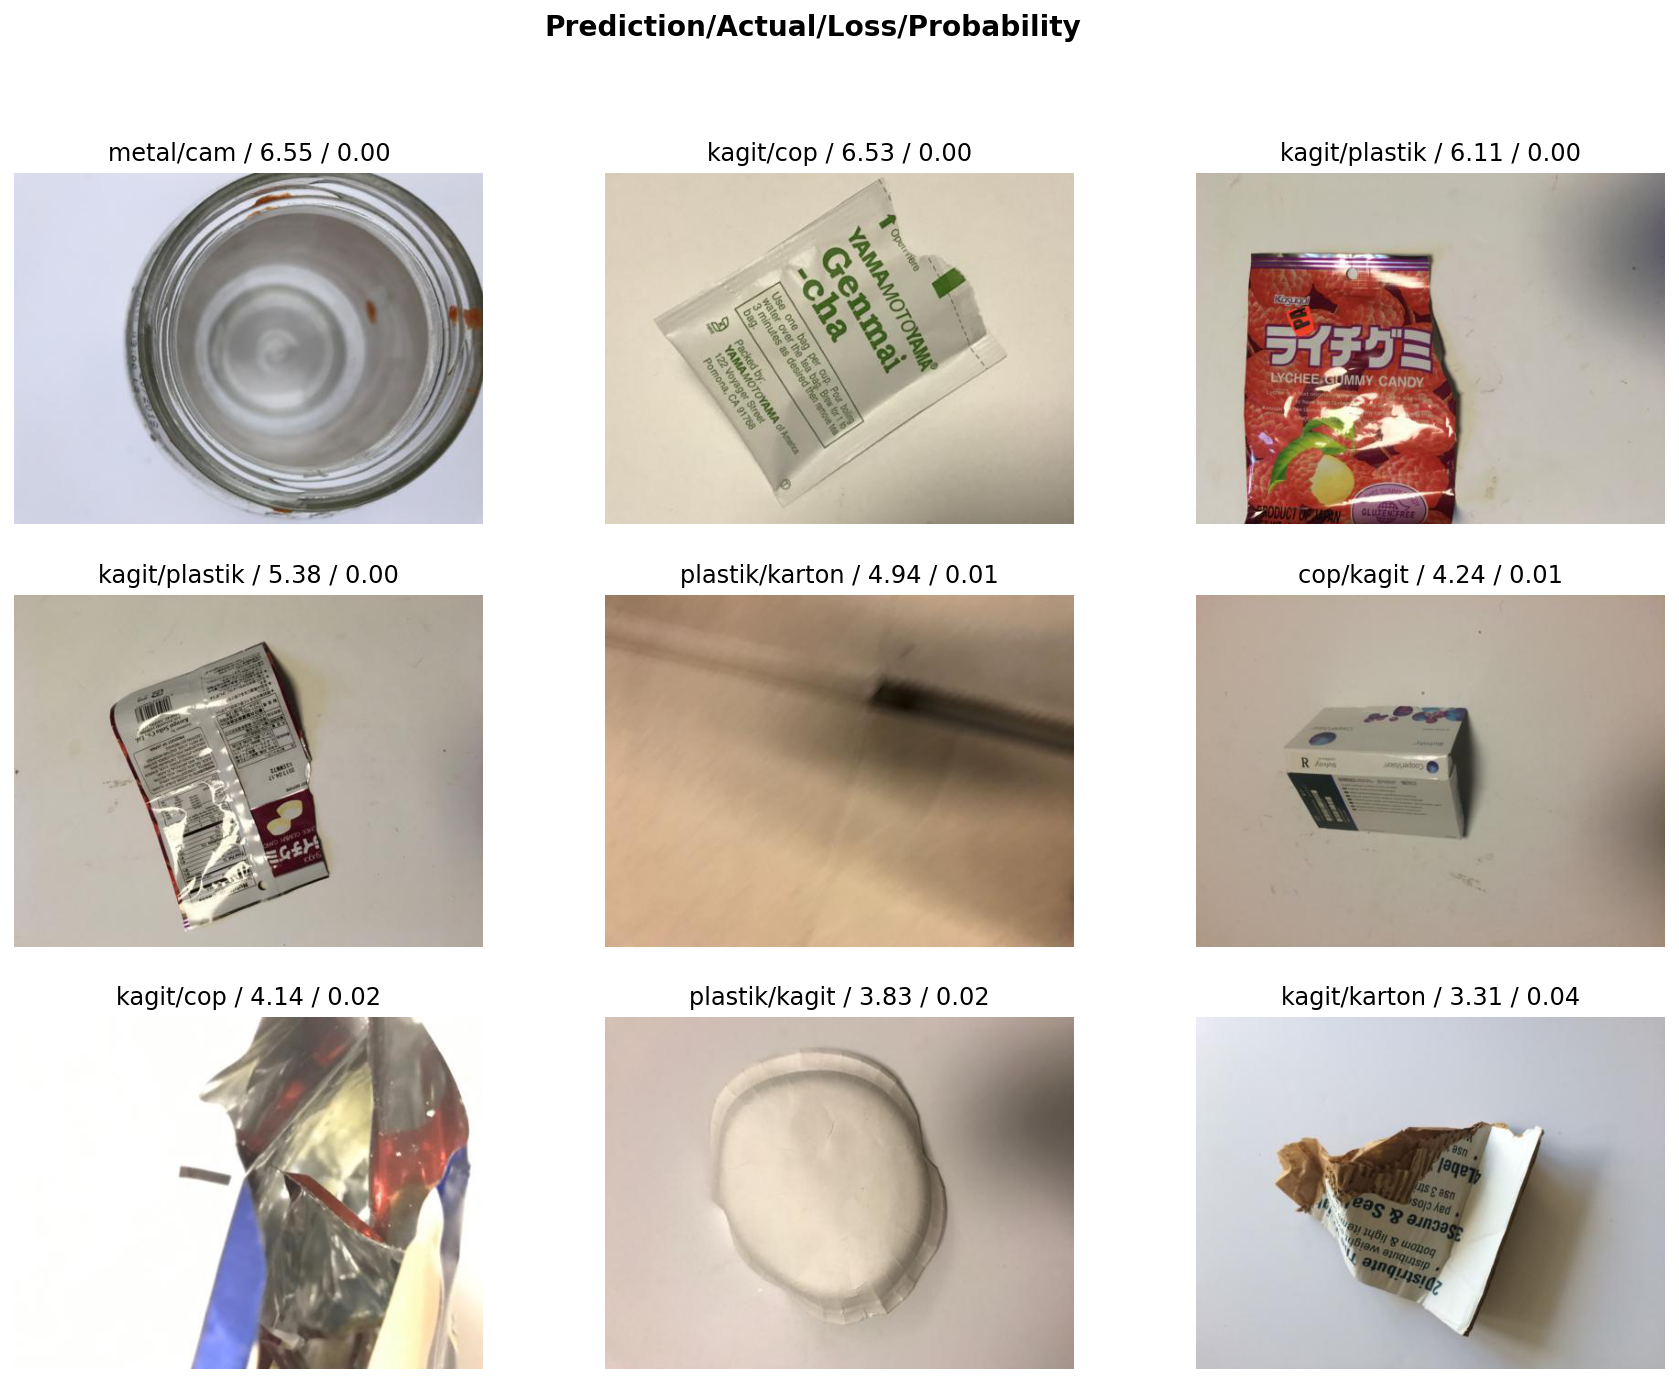

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

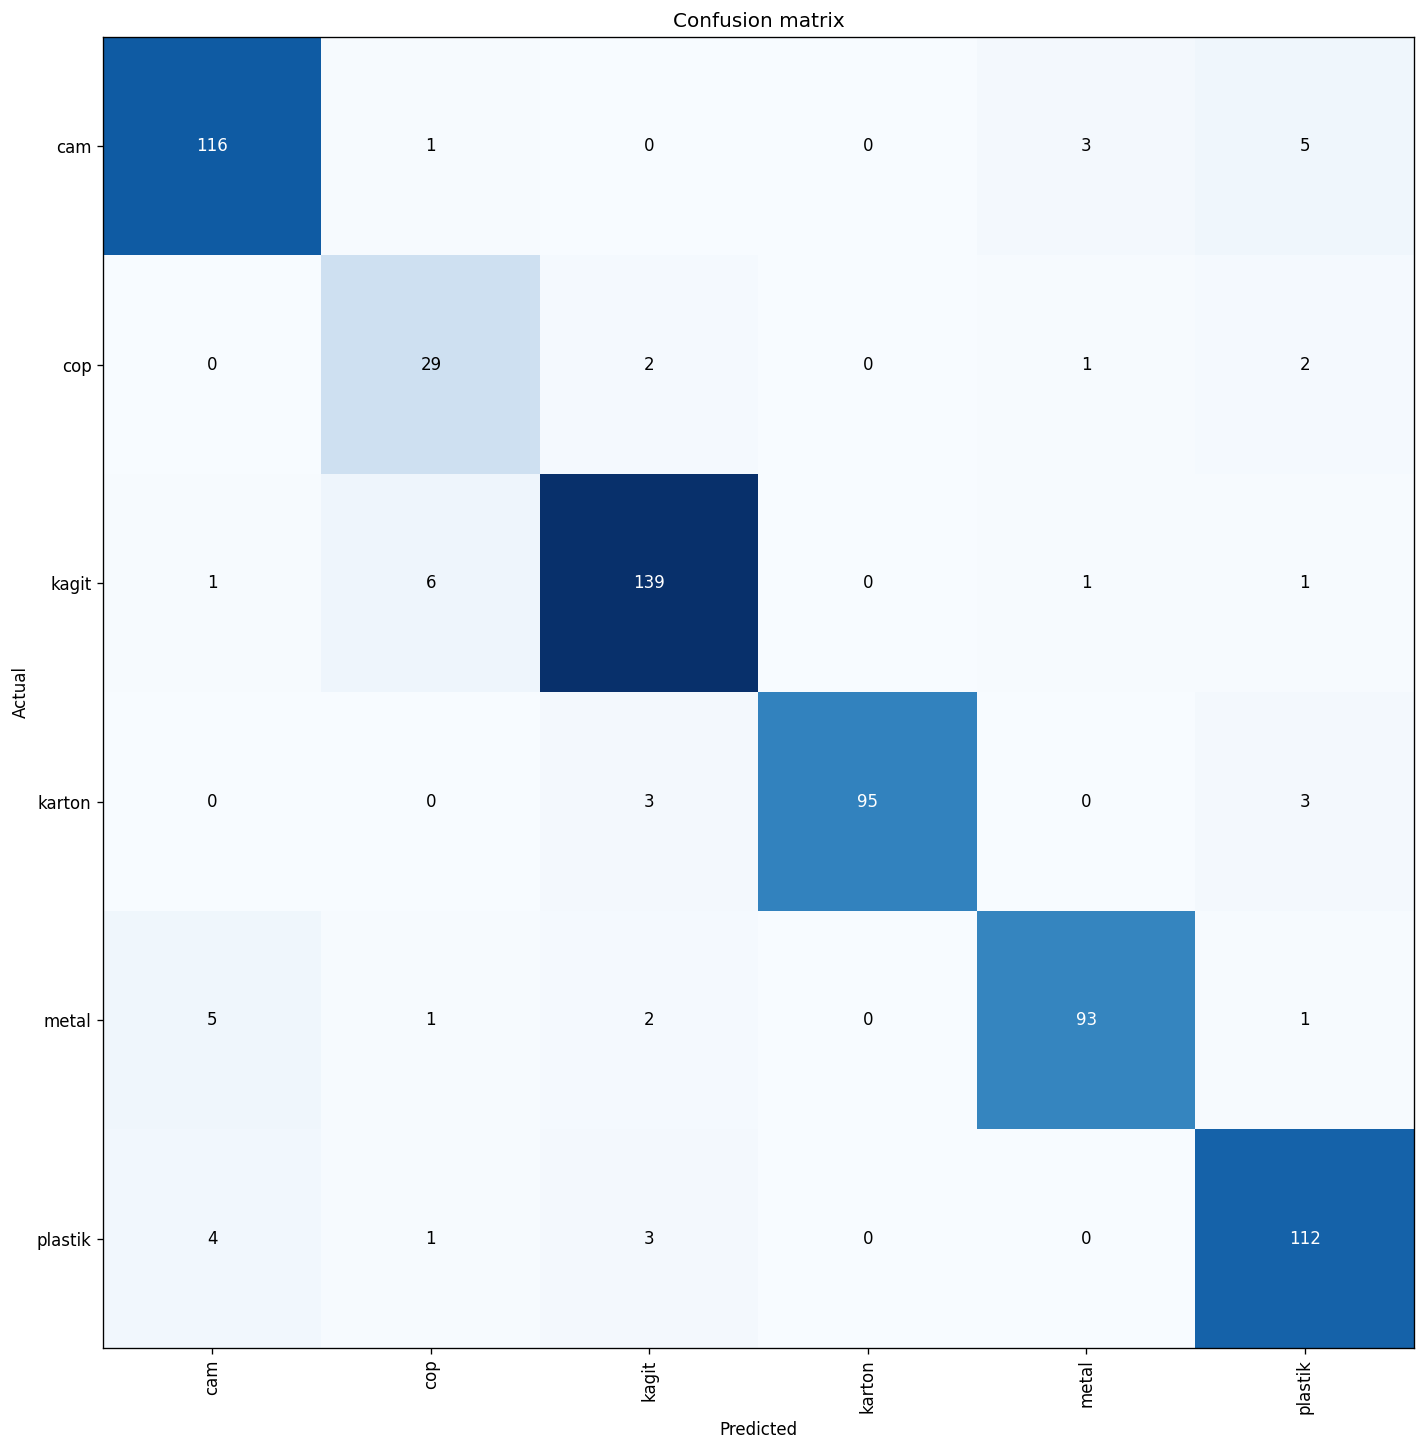

In [0]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('kagit', 'cop', 6),
 ('cam', 'plastik', 5),
 ('metal', 'cam', 5),
 ('plastik', 'cam', 4),
 ('cam', 'metal', 3),
 ('karton', 'kagit', 3),
 ('karton', 'plastik', 3),
 ('plastik', 'kagit', 3),
 ('cop', 'kagit', 2),
 ('cop', 'plastik', 2),
 ('metal', 'kagit', 2)]

In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[3.0438e-03, 4.6821e-02, 7.4202e-03, 2.8162e-01, 6.3889e-01, 2.2206e-02],
        [9.7747e-01, 3.1602e-03, 1.6654e-03, 1.0870e-04, 1.5974e-02, 1.6231e-03],
        [2.7916e-07, 3.2111e-06, 9.9999e-01, 8.9347e-06, 1.3855e-06, 1.8658e-07],
        ...,
        [6.7225e-06, 9.9557e-01, 5.0093e-04, 3.0389e-04, 3.0853e-04, 3.3122e-03],
        [3.3889e-06, 3.0063e-06, 7.4517e-08, 1.9023e-08, 9.9999e-01, 2.1878e-06],
        [5.4550e-09, 1.0243e-10, 1.0000e+00, 1.8351e-07, 1.6290e-09, 1.1025e-08]])

In [0]:
data.classes

['cam', 'cop', 'kagit', 'karton', 'metal', 'plastik']

In [0]:
# Her resim için en maksimum sınıfın dizinini kaydeder.

max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

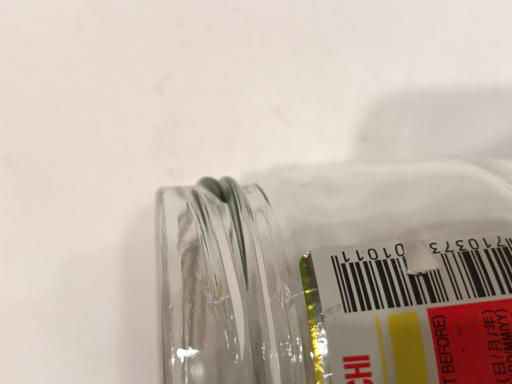

In [0]:
# İlk indis değiştirmek yeterli

learn.data.test_ds[420][0]

In [0]:
yhat[420]

'cam'

In [0]:
y = []

# POSIX yollarını önce diziye dönüştür.

for label_path in data.test_ds.items:
    y.append(str(label_path))
    
# Daha sonra dosya yolundan atık türünü çıkarılması

pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [0]:
# Öngörülen değerler
print(yhat[5:18])
# Gerçek değerler
print(y[5:18])

['kagit', 'cam', 'karton', 'plastik', 'metal', 'kagit', 'kagit', 'plastik', 'metal', 'cam', 'plastik', 'kagit', 'plastik']
['kagit', 'cam', 'karton', 'plastik', 'metal', 'kagit', 'kagit', 'plastik', 'plastik', 'cam', 'plastik', 'kagit', 'plastik']


In [0]:
cm = confusion_matrix(y,yhat)
print(cm)

[[120   0   0   0   2   4]
 [  1  30   4   0   0   0]
 [  0   0 147   0   1   1]
 [  1   1   2  96   1   0]
 [  7   3   0   0  93   0]
 [  7   3   0   1   2 108]]


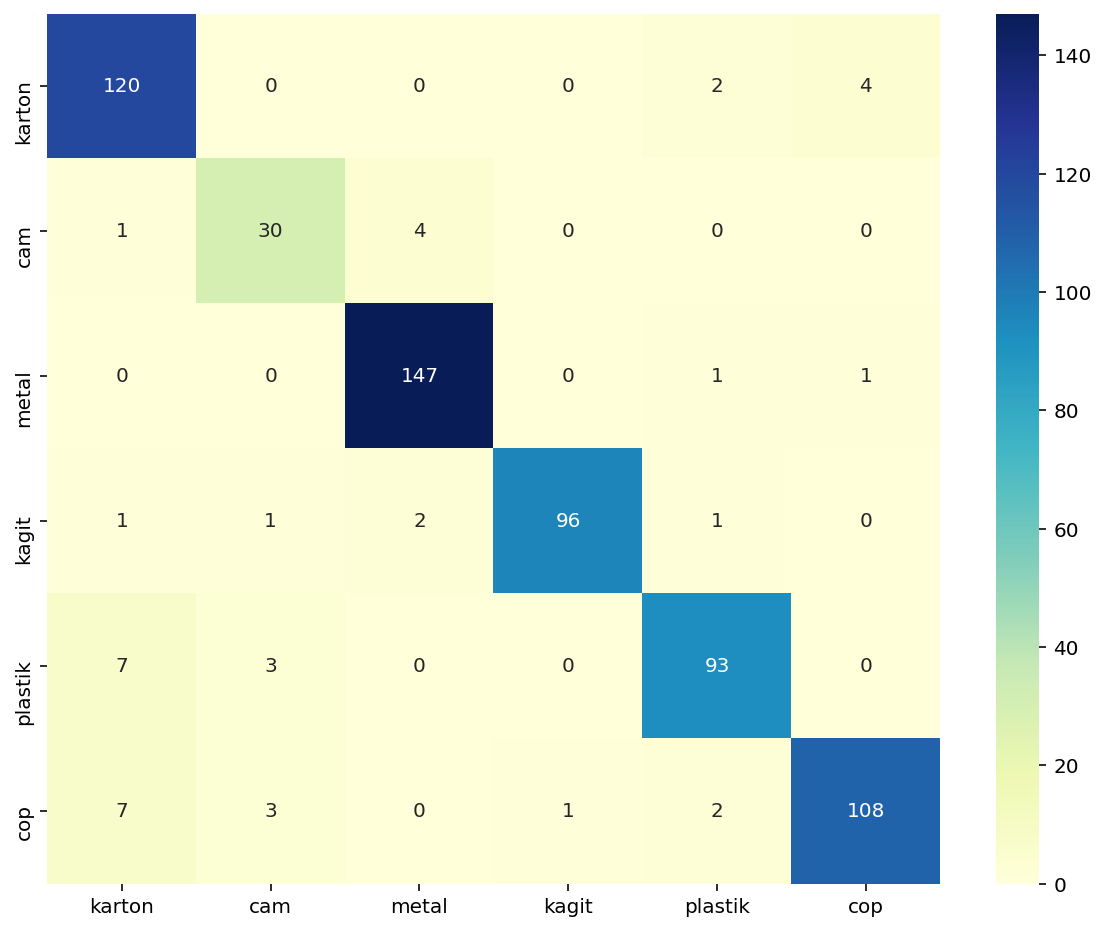

In [0]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [0]:
accuracy = correct/sum(sum(cm))
accuracy

0.9354330708661417